In [5]:
import utilities as utils
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier


    Last Execution: 2022-04-03 14:10:25.048625
    python:	3.8.5

    	fastai:		2.5.6
    	matplotlib:	3.5.1
    	numpy:		1.19.5
    	pandas:		1.4.1
    	seaborn:	0.11.2
    	sklearn:	1.0.2
    	torch:		1.11.0+cu102
    	yellowbrick:	1.4
    	imblearn:	0.9.0
    


/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [6]:
data_path_1: str = './synthetic/'   
data_path_2: str = '../../../Data/phase1/'   

data_set_1: list = [ 'smote_balanced_application_dataset_labels_10_10_10.csv',
                     'smote_balanced_application_dataset_labels_15_15_15.csv',
                     'smote_balanced_application_dataset_labels_20_20_20.csv',
                     'smote_balanced_application_dataset_labels_25_25_25.csv',
                     'smote_balanced_application_dataset_labels_30_30_30.csv',
                     'smote_balanced_application_dataset_labels_equal.csv',
                     'smote_balanced_application_dataset_labels_proportional.csv',
                     'smote_balanced_traffic_dataset_labels_20_15_5.csv',
                     'smote_balanced_traffic_dataset_labels_20_20_20.csv',
                     'smote_balanced_traffic_dataset_labels_30_20_10.csv',
                     'smote_balanced_traffic_dataset_labels_equal.csv']

data_set_2: list = [ 'Darknet_reduced_features.csv' ] 


file_path_1       = utils.get_file_path(data_path_1)
file_path_2       = utils.get_file_path(data_path_2)
file_set_1 : list = list(map(file_path_1, data_set_1))
file_set_2 : list = list(map(file_path_2, data_set_2))

file_set : list   = file_set_1 + file_set_2
data_set   : list = data_set_1 + data_set_2
current_job: int  = 0

utils.data_set = data_set
utils.file_set = file_set

In [7]:
print(f'We will be using {len(file_set)} files:')
utils.pretty(file_set)

We will be using 12 files:
[   './synthetic/smote_balanced_application_dataset_labels_10_10_10.csv',
    './synthetic/smote_balanced_application_dataset_labels_15_15_15.csv',
    './synthetic/smote_balanced_application_dataset_labels_20_20_20.csv',
    './synthetic/smote_balanced_application_dataset_labels_25_25_25.csv',
    './synthetic/smote_balanced_application_dataset_labels_30_30_30.csv',
    './synthetic/smote_balanced_application_dataset_labels_equal.csv',
    './synthetic/smote_balanced_application_dataset_labels_proportional.csv',
    './synthetic/smote_balanced_traffic_dataset_labels_20_15_5.csv',
    './synthetic/smote_balanced_traffic_dataset_labels_20_20_20.csv',
    './synthetic/smote_balanced_traffic_dataset_labels_30_20_10.csv',
    './synthetic/smote_balanced_traffic_dataset_labels_equal.csv',
    '../../../Data/phase1/Darknet_reduced_features.csv']


In [8]:
smote_balanced_application_dataset_labels_10_10_10 = utils.examine_dataset(1)
smote_balanced_application_dataset_labels_15_15_15 = utils.examine_dataset(2)
smote_balanced_application_dataset_labels_20_20_20 = utils.examine_dataset(3)
smote_balanced_application_dataset_labels_25_25_25 = utils.examine_dataset(4)
smote_balanced_application_dataset_labels_30_30_30 = utils.examine_dataset(5)
smote_balanced_application_dataset_labels_equal = utils.examine_dataset(6)
smote_balanced_application_dataset_labels_proportional = utils.examine_dataset(7)
smote_balanced_traffic_labels_dataset_20_15_5 = utils.examine_dataset(8)
smote_balanced_traffic_labels_dataset_20_20_20 = utils.examine_dataset(9)
smote_balanced_traffic_labels_dataset_30_20_10 = utils.examine_dataset(10)
smote_balanced_traffic_labels_dataset_equal = utils.examine_dataset(11)
baseline = utils.examine_dataset(12)

Dataset 1/12: We now look at ./synthetic/smote_balanced_application_dataset_labels_10_10_10.csv


Loading Dataset: ./synthetic/smote_balanced_application_dataset_labels_10_10_10.csv
	To Dataset Cache: ./cache/smote_balanced_application_dataset_labels_10_10_10.csv.pickle


        File:				./synthetic/smote_balanced_application_dataset_labels_10_10_10.csv  
        Job Number:			1
        Shape:				(80000, 63)
        Samples:			80000 
        Features:			63
    
Dataset 2/12: We now look at ./synthetic/smote_balanced_application_dataset_labels_15_15_15.csv


Loading Dataset: ./synthetic/smote_balanced_application_dataset_labels_15_15_15.csv
	To Dataset Cache: ./cache/smote_balanced_application_dataset_labels_15_15_15.csv.pickle


        File:				./synthetic/smote_balanced_application_dataset_labels_15_15_15.csv  
        Job Number:			2
        Shape:				(120000, 63)
        Samples:			120000 
        Features:			63
    
Dataset 3/12: We now look at ./synthetic/smote_balanced_applicat

In [46]:
def run_shallow_learning_experiment(df: utils.pd.DataFrame, name: str, target_label: str, classifier, split=0.2, categorical : list = ['Protocol'], leave_out: list = []) -> utils.Model_data:
    '''
        Run binary classification using a shallow learning model
        returns the 10-tuple Model_data
    '''

    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var: str = target_label

    categorical_features: list = []
    untouched_features  : list = []

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)
        
    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]) - set(untouched_features))

    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [utils.FillMissing, utils.Categorify, utils.Normalize]
    splits = utils.RandomSplitter(valid_pct=split, seed=utils.seed)(utils.range_of(df))
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = utils.TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # We use fastai to quickly extract the names of the classes as they are mapped to the encodings
    dls = to.dataloaders(bs=64)
    model = utils.tabular_learner(dls)
    classes : list = list(model.dls.vocab)


    # extract the name from the path
    p = utils.pathlib.Path(name)
    name: str = str(p.parts[-1])


    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()


    # Now that we have the train and test datasets, we set up a gridsearch of the K-NN classifier
    # using SciKitLearn and print the results 
    model = classifier
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    prediction_prob = model.predict_proba(X_test)
    report = utils.classification_report(y_test, prediction)
    print(f"Results for {name}")
    print(report)
    print(f'\tAccuracy: {utils.accuracy_score(y_test, prediction)}\n')
    print(f'\tF1: {utils.f1_score(y_test, prediction, average="weighted")}\n')
    print(f'\tAUC: {utils.roc_auc_score(y_test, prediction_prob, multi_class="ovr")}\n')
    print(f'\tMathew\'s Correlation: {utils.matthews_corrcoef(y_test, prediction)}\n')

   # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    if len(classes) == 2:
        model.target_type_ = 'binary'
    elif len(classes) > 2:  
        model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')

    model_data: utils.Model_data = utils.Model_data(name, model, classes, X_train, y_train, X_test, y_test, to, dls, name)

    
    # Now that the classifier has been created and trained, we pass out our training values
    # for analysis and further experimentation
    return model_data

def run_deep_nn_experiment(
    df: utils.pd.DataFrame, 
    file_name: str, 
    target_label: str, 
    shape: tuple, 
    split=0.2, 
    categorical: list = ['Protocol'],
    procs = [utils.FillMissing, utils.Categorify, utils.Normalize], 
    leave_out: list = [],
    epochs: int = 10,
    batch_size: int = 64,
    metrics: list or None = None,
    callbacks: list = [utils.ShowGraphCallback],
    lr_choice: str = 'valley',
    name: str or None = None,
) -> utils.Model_data:
    '''
        Function trains a deep neural network model on the given data. 

        Parameters:
            df: pandas dataframe containing the data
            file_name: name of the file the dataset came from
            target_label: the label to predict
            shape: the shape of the neural network, the i-th value in the tuple represents the number of nodes in the i+1 layer
                    and the number of entries in the tuple represent the number of layers
            name: name of the experiment, if none a default is given
            split: the percentage of the data to use for testing
            categorical: list of the categorical columns
            procs: list of preprocessing functions to apply in the dataloaders pipeline
                    additional options are: 
                        PCA_tabular (generate n principal components) 
                        Normal (features are scaled to the interval [0,1])
            leave_out: list of columns to leave out of the experiment
            epochs: number of epochs to train for
            batch_size: number of samples processed in one forward and backward pass of the model
            metrics: list of metrics to calculate and display during training
            callbacks: list of callbacks to apply during training
            lr_choice: where the learning rate sampling function should find the optimal learning rate
                        choices are: 'valley', 'steep', 'slide', and 'minimum'
         
        
        returns a model data named tuple
            model_data: tuple = (file_name, model, classes, X_train, y_train, X_test, y_test, model_type)
    '''
    shape = tuple(shape)

    if name is None:
        width: int = shape[0]
        for x in shape:
            width = x if (x > width) else width
        name = f'Deep_NN_{len(shape)}x{width}'

    lr_choice = {'valley': 0, 'slide': 1, 'steep': 2, 'minimum': 3}[lr_choice]


    categorical_features: list = []
    untouched_features  : list = []

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

        
    if metrics is None:
        metrics = [utils.accuracy, utils.BalancedAccuracy(), utils.RocAuc(), utils.MatthewsCorrCoef(), utils.F1Score(average='macro'), utils.Precision(average='macro'), utils.Recall(average='macro')]


    continuous_features = list(set(df) - set(categorical_features) - set([target_label]) - set(untouched_features))

    splits = utils.RandomSplitter(valid_pct=split, seed=utils.seed)(utils.range_of(df))
    

    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = utils.TabularPandas(
        df            , y_names=target_label                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # The dataframe is then converted into a fastai dataset
    dls = to.dataloaders(bs=batch_size)

    # extract the file_name from the path
    p = utils.pathlib.Path(file_name)
    file_name: str = str(p.parts[-1])


    learner = utils.tabular_learner(
        dls, 
        layers=list(shape), 
        metrics = metrics,
        cbs=callbacks,
    )

   

    # fitting functions, they give different results, some networks perform better with different learning schedule during fitting
    # learner.fit(epochs, lr[lr_choice])
    # learner.fit_flat_cos(epochs, lr[lr_choice])
    with learner.no_bar(), learner.no_logging():
        lr = learner.lr_find(suggest_funcs=[utils.valley, utils.slide, utils.steep, utils.minimum])

        
        learner.fit_one_cycle(epochs, lr_max=lr[lr_choice])

        learner.save(f'{file_name}.model')

        #learner.recorder.plot_sched() 
        results = learner.validate()
        
        print(f'loss: {results[0]}, accuracy: {results[1]*100: .2f}%')

        #interp = utils.ClassificationInterpretation.from_learner(learner)
    #interp.plot_confusion_matrix()

    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()

    wrapped_model = utils.SklearnWrapper(learner)
    
    wrapped_model.fit(X_train, y_train)
    prediction = wrapped_model.predict(X_test)
    prediction_prob = wrapped_model.predict_proba(X_test)
    report = utils.classification_report(y_test, prediction)
    print(f"Results for {name}")
    print(report)
    print(f'\tAccuracy: {utils.accuracy_score(y_test, prediction)}\n')
    print(f'\tF1: {utils.f1_score(y_test, prediction, average="weighted")}\n')
    print(f'\tAUC: {utils.roc_auc_score(y_test, prediction_prob, multi_class="ovr")}\n')
    print(f'\tMathew\'s Correlation: {utils.matthews_corrcoef(y_test, prediction)}\n')

    classes = list(learner.dls.vocab)
    if len(classes) == 2:
        wrapped_model.target_type_ = 'binary'
    elif len(classes) > 2:  
        wrapped_model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')
    
    wrapped_model._target_labels = target_label
    
    model_data: utils.Model_data = utils.Model_data(file_name, wrapped_model, classes, X_train, y_train, X_test, y_test, to, dls, name)


    return model_data

def run_residual_deep_nn_experiment(
    df: utils.pd.DataFrame, 
    file_name: str, 
    target_label: str, 
    shape: tuple, 
    split=0.2, 
    categorical: list = ['Protocol'],
    procs = [utils.FillMissing, utils.Categorify, utils.Normalize], 
    leave_out: list = [],
    epochs: int = 10,
    batch_size: int = 64,
    metrics: list or None = None,
    callbacks: list = [utils.ShowGraphCallback],
    lr_choice: str = 'valley',
    name: str or None = None,
) -> utils.Model_data:
    '''
        Function trains a residual deep neural network model on the given data. 
            Based on ResNet from Deep Residual Learning for Image Recognition by He et al. (2016) 
            but adapted to tabular data using the answer given here 
        
        (https://stackoverflow.com/questions/57229054/how-to-implement-my-own-resnet-with-torch-nn-sequential-in-pytorch)
        (https://arxiv.org/abs/1512.03385)

        Parameters:
            df: pandas dataframe containing the data
            file_name: name of the file the dataset came from
            target_label: the label to predict
            shape: the shape of the neural network, the i-th value in the tuple represents the number of nodes in the i+1 layer
                    and the number of entries in the tuple represent the number of layers
            name: name of the experiment, if none a default is given
            split: the percentage of the data to use for testing
            categorical: list of the categorical columns
            procs: list of preprocessing functions to apply in the dataloaders pipeline
                    additional options are: 
                        PCA_tabular (generate n principal components) 
                        Normal (features are scaled to the interval [0,1])
            leave_out: list of columns to leave out of the experiment
            epochs: number of epochs to train for
            batch_size: number of samples processed in one forward and backward pass of the model
            metrics: list of metrics to calculate and display during training
            callbacks: list of callbacks to apply during training
            lr_choice: where the learning rate sampling function should find the optimal learning rate
                        choices are: 'valley', 'steep', 'slide', and 'minimum'
         
        
        returns a model data named tuple
            model_data: tuple = (file_name, model, classes, X_train, y_train, X_test, y_test, model_type)
    '''
    shape = tuple(shape)

    if name is None:
        width: int = shape[0]
        for x in shape:
            width = x if (x > width) else width
        name = f'Residual_1D_Deep_NN_{len(shape)}x{width}'

    lr_choice = {'valley': 0, 'slide': 1, 'steep': 2, 'minimum': 3}[lr_choice]


    categorical_features: list = []
    untouched_features  : list = []

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

        
    if metrics is None:
        metrics = [utils.accuracy, utils.BalancedAccuracy(), utils.RocAuc(), utils.MatthewsCorrCoef(), utils.F1Score(average='macro'), utils.Precision(average='macro'), utils.Recall(average='macro')]


    continuous_features = list(set(df) - set(categorical_features) - set([target_label]) - set(untouched_features))

    splits = utils.RandomSplitter(valid_pct=split, seed=utils.seed)(utils.range_of(df))
    

    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = utils.TabularPandas(
        df            , y_names=target_label                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # The dataframe is then converted into a fastai dataset
    dls = to.dataloaders(bs=batch_size)

    # extract the file_name from the path
    p = utils.pathlib.Path(file_name)
    file_name: str = str(p.parts[-1])


    learner = utils.residual_tabular_learner(
        dls, 
        layers=list(shape), 
        metrics = metrics,
        cbs=callbacks,
    )
    with learner.no_bar(), learner.no_logging():
        lr = learner.lr_find(suggest_funcs=[utils.valley, utils.slide, utils.steep, utils.minimum])


        # fitting functions, they give different results, some networks perform better with different learning schedule during fitting
        # learner.fit(epochs, lr[lr_choice])
        # learner.fit_flat_cos(epochs, lr[lr_choice])
        learner.fit_one_cycle(epochs, lr_max=lr[lr_choice])

        learner.save(f'{file_name}.model')

        learner.recorder.plot_sched() 
        results = learner.validate()
    
    #interp = utils.ClassificationInterpretation.from_learner(learner)

    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()

    wrapped_model = utils.SklearnWrapper(learner)

    classes = list(learner.dls.vocab)
    if len(classes) == 2:
        wrapped_model.target_type_ = 'binary'
    elif len(classes) > 2:  
        wrapped_model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')
    
    wrapped_model._target_labels = target_label
    
    wrapped_model.fit(X_train, y_train)
    prediction = wrapped_model.predict(X_test)
    prediction_prob = wrapped_model.predict_proba(X_test)
    report = utils.classification_report(y_test, prediction)
    print(f"Results for {name}")
    print(report)
    print(f'\tAccuracy: {utils.accuracy_score(y_test, prediction)}\n')
    print(f'\tF1: {utils.f1_score(y_test, prediction, average="weighted")}\n')
    print(f'\tAUC: {utils.roc_auc_score(y_test, prediction_prob, multi_class="ovr")}\n')
    print(f'\tMathew\'s Correlation: {utils.matthews_corrcoef(y_test, prediction)}\n')
    
    model_data: utils.Model_data = utils.Model_data(file_name, wrapped_model, classes, X_train, y_train, X_test, y_test, to, dls, name)


    return model_data

def run_tabnet_experiment(
    df: utils.pd.DataFrame, 
    file_name: str, 
    target_label: str, 
    split=0.2, 
    name: str or None = None,
    categorical: list = ['Protocol'],
    procs = [utils.FillMissing, utils.Categorify, utils.Normalize], 
    leave_out: list = [],
    epochs: int = 10,
    steps: int = 1,
    batch_size: int = 64,
    metrics: list or None = None,
    attention_size: int = 16,
    attention_width: int = 16,
    callbacks: list = [utils.ShowGraphCallback],
    lr_choice: str = 'valley',
) -> utils.Model_data:
    '''
    Function trains a TabNet model on the dataframe and returns a model data named tuple
        Based on TabNet: Attentive Interpretable Tabular Learning by Sercan Arik and Tomas Pfister from Google Cloud AI (2016)
            where a DNN selects features from the input features based on an attention layer. Each step of the model selects 
            different features and uses the input from the previous step to ultimately make predictions
    
        Combines aspects of a transformer, decision trees, and deep neural networks to learn tabular data, and has achieved state
            of the art results on some datasets.

        Capable of self-supervised learning, however it is not implemented here yet.

    (https://arxiv.org/pdf/1908.07442.pdf)

    Parameters:
        df: pandas dataframe containing the data
        file_name: name of the file the dataset came from
        target_label: the label to predict
        name: name of the experiment, if none a default is given
        split: the percentage of the data to use for testing
        categorical: list of the categorical columns
        procs: list of preprocessing functions to apply in the dataloaders pipeline
                additional options are: 
                    PCA_tabular (generate n principal components) 
                    Normal (features are scaled to the interval [0,1])
        leave_out: list of columns to leave out of the experiment
        epochs: number of epochs to train for
        batch_size: number of samples processed in one forward and backward pass of the model
        metrics: list of metrics to calculate and display during training
        attention size: determines the number of rows and columns in the attention layers
        attention width: determines the width of the decision layer
        callbacks: list of callbacks to apply during training
        lr_choice: where the learning rate sampling function should find the optimal learning rate
                    choices are: 'valley', 'steep', 'slide', and 'minimum'
        
    
    returns a model data named tuple
        model_data: tuple = (file_name, model, classes, X_train, y_train, X_test, y_test, model_type)
    '''

    if name is None:
        name = f"TabNet_steps_{steps}_width_{attention_width}_attention_{attention_size}"

    lr_choice = {'valley': 0, 'slide': 1, 'steep': 2, 'minimum': 3}[lr_choice]


    categorical_features: list = []
    untouched_features  : list = []

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

        
    if metrics is None:
        metrics = [utils.accuracy, utils.BalancedAccuracy(), utils.RocAuc(), utils.MatthewsCorrCoef(), utils.F1Score(average='macro'), utils.Precision(average='macro'), utils.Recall(average='macro')]


    continuous_features = list(set(df) - set(categorical_features) - set([target_label]) - set(untouched_features))

    splits = utils.RandomSplitter(valid_pct=split, seed=utils.seed)(utils.range_of(df))
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up

    to = utils.TabularPandas(
        df            , y_names=target_label                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # The dataframe is then converted into a fastai dataset
    dls = to.dataloaders(bs=batch_size)

    # extract the file_name from the path
    p = utils.pathlib.Path(file_name)
    file_name: str = str(p.parts[-1])


    emb_szs = utils.get_emb_sz(to)


    net = utils.TabNet(emb_szs, len(to.cont_names), dls.c, n_d=attention_width, n_a=attention_size, n_steps=steps) 
    tab_model = utils.Learner(dls, net, loss_func=utils.CrossEntropyLossFlat(), metrics=metrics, opt_func=utils.ranger, cbs=callbacks)


    with tab_model.no_bar(), tab_model.no_logging():
        lr = tab_model.lr_find(suggest_funcs=[utils.valley, utils.slide, utils.steep, utils.minimum])

        # tab_model.fit_flat_cos(epochs, lr[lr_choice])
        tab_model.fit_one_cycle(epochs, lr[lr_choice])

        tab_model.save(f'{file_name}.model')

        tab_model.recorder.plot_sched() 
        results = tab_model.validate()
    


    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()

    wrapped_model = utils.SklearnWrapper(tab_model)
    
    wrapped_model.fit(X_train, y_train)
    prediction = wrapped_model.predict(X_test)
    prediction_prob = wrapped_model.predict_proba(X_test)
    report = utils.classification_report(y_test, prediction)
    print(f"Results for {name}")
    print(report)
    print(f'\tAccuracy: {utils.accuracy_score(y_test, prediction)}\n')
    print(f'\tF1: {utils.f1_score(y_test, prediction, average="weighted")}\n')
    print(f'\tAUC: {utils.roc_auc_score(y_test, prediction_prob, multi_class="ovr")}\n')
    print(f'\tMathew\'s Correlation: {utils.matthews_corrcoef(y_test, prediction)}\n')

    classes = list(tab_model.dls.vocab)
    if len(classes) == 2:
        wrapped_model.target_type_ = 'binary'
    elif len(classes) > 2:  
        wrapped_model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')
    
    wrapped_model._target_labels = target_label
    
    model_data: utils.Model_data = utils.Model_data(file_name, wrapped_model, classes, X_train, y_train, X_test, y_test, to, dls, name)


    return model_data



In [35]:
def visualize_side_by_side(
    model_datum: list,
    title: str = "Confusion Matrices",
    model_descriptions: list or None = None,
    plotting_function: callable = utils.visualize_confusion_matrix,
    shape: tuple = (2,5),
    size: tuple = (20,10),
    x_label: str = 'Predicted',
    y_label: str = 'True',
) -> tuple:
    '''
        Function will take the plotting function and execute it on each Model_data tuple passed in through the model_datum list
            The plots will be oriented in a subplot grid with the number of rows and columns specified by the shape tuple
            average accuracy will be calculated and displayed in the subtitle of the figure
            
    '''

    print('Ignore yellowbrick warnings, this is a side-effect of using the sklearn wrapper on the fastai model')
    rows = shape[0]
    cols = shape[1]

    fig, ax = utils.plt.subplots(nrows=rows, ncols=cols, figsize=size)
    fig.suptitle(title)

    viz: list = [0] * len(model_datum)
    for i in range(rows*cols):
        row = i // cols
        col = i % cols
        if i < len(model_datum):
            if(rows == 1):
                current_ax = ax[col]
            else:
                current_ax = ax[row][col]
            viz[i] = plotting_function(model_datum[i], ax=current_ax)
            viz[i].finalize()
            if model_descriptions is not None:
                current_ax.set_title(model_descriptions[i])

        if(row == rows-1):
            current_ax.set_xlabel(x_label)
        else:
            current_ax.set_xlabel('')
            current_ax.xaxis.set_ticklabels([])

        if(col == 0):
            current_ax.set_ylabel(y_label)
        else:
            current_ax.set_ylabel('')
            current_ax.yaxis.set_ticklabels([])

    utils.plt.tight_layout()

    return (fig, ax)

In [56]:
def train_and_evaluate_n_classifiers(df: utils.pd.DataFrame, classifiers: list, target_label: str, classifier_names: list, shallow_classifiers: list, shape : tuple, chart_title : str, epochs: int = 10) -> list:
    model_results : list = []
    for i, classifier in enumerate(classifiers):
        if classifier_names[i] in shallow_classifiers:
            model_results.append(run_shallow_learning_experiment(df, classifier_names[i],target_label, classifier))
        elif classifier == "Deep Neural Network":
            model_results.append(run_deep_nn_experiment(df, classifier_names[i], target_label, shape, callbacks=[], epochs=epochs, name=classifier_names[i]))
        elif classifier == "Residual Neural Network":
            model_results.append(run_residual_deep_nn_experiment(df, classifier_names[i], target_label, shape, callbacks=[], epochs=epochs, name=classifier_names[i]))
        else:
            model_results.append(run_tabnet_experiment(df, classifier_names[i], target_label, callbacks=[], epochs=epochs, name=classifier_names[i]))
    visualize_side_by_side(model_results, chart_title, classifier_names, shape=(2,4), size=(20,10))
    return model_results

# Baseline Results

In [ ]:
baseline_dataset = utils.package_data_for_inspection_with_label(
                utils.reduce_feature_to_values(baseline['Dataset'], 'Traffic Type', ['Tor', 'VPN', 'Non-Tor'] ), 'Dataset_2')

baseline_dataset['Dataset'] = utils.rename_values_in_column(baseline_dataset, [('Traffic Type', {'Non-Tor': 'Regular'})])

baseline_traffic_dataset : dict = utils.package_data_for_inspection_with_label(
                         utils.prune_dataset(baseline_dataset, ['Application Type']), 'Traffic_Dataset_2_Tor_VPN_Regular')

baseline_application_dataset : dict = utils.package_data_for_inspection_with_label(
                            utils.prune_dataset(baseline_dataset, ['Traffic Type']), 'Application_Dataset_1')

Results for Linear Discriminant Analysis
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18739
           1       0.85      0.83      0.84       275
           2       0.98      0.85      0.91      4510

    accuracy                           0.97     23524
   macro avg       0.93      0.89      0.91     23524
weighted avg       0.97      0.97      0.97     23524

	Accuracy: 0.9667148444142153

	F1: 0.9657392507308975

	AUC: 0.963996913327238

	Mathew's Correlation: 0.8967774819632586

Results for Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18739
           1       0.99      0.97      0.98       275
           2       1.00      1.00      1.00      4510

    accuracy                           1.00     23524
   macro avg       0.99      0.99      0.99     23524
weighted avg       1.00      1.00      1.00     23524

	Accuracy: 0.9983846284645469

	F1: 0.998383134

/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:20:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Results for XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18739
           1       0.99      0.98      0.99       275
           2       1.00      1.00      1.00      4510

    accuracy                           1.00     23524
   macro avg       1.00      0.99      0.99     23524
weighted avg       1.00      1.00      1.00     23524

	Accuracy: 0.9984696480190444

	F1: 0.9984688813541744

	AUC: 0.9999686732486154

	Mathew's Correlation: 0.9953407843266753

Results for K-Nearest Neighbors
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18739
           1       0.98      0.92      0.95       275
           2       0.99   

/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be rem

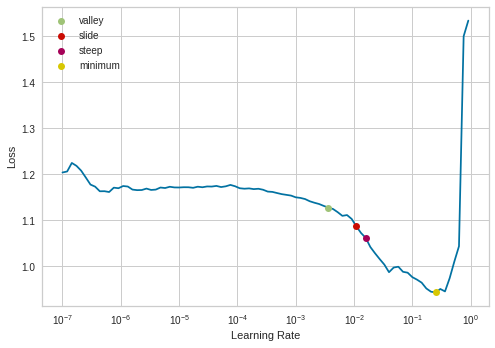

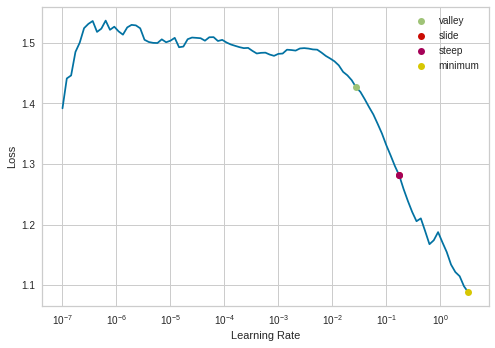

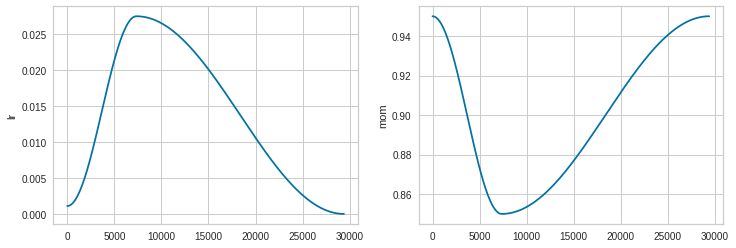

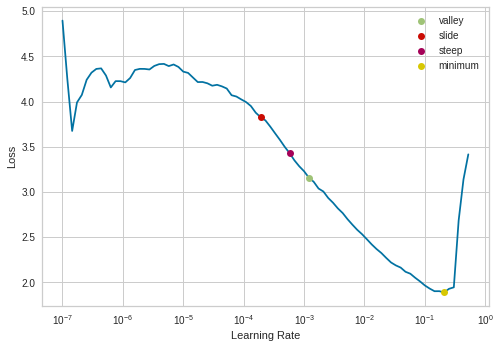

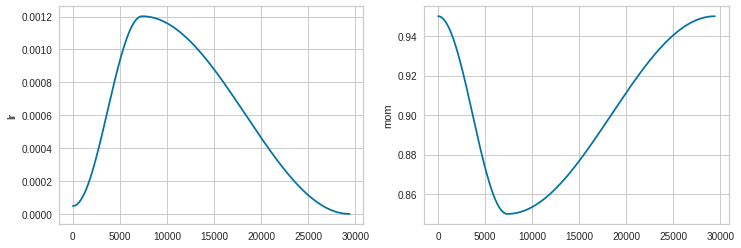

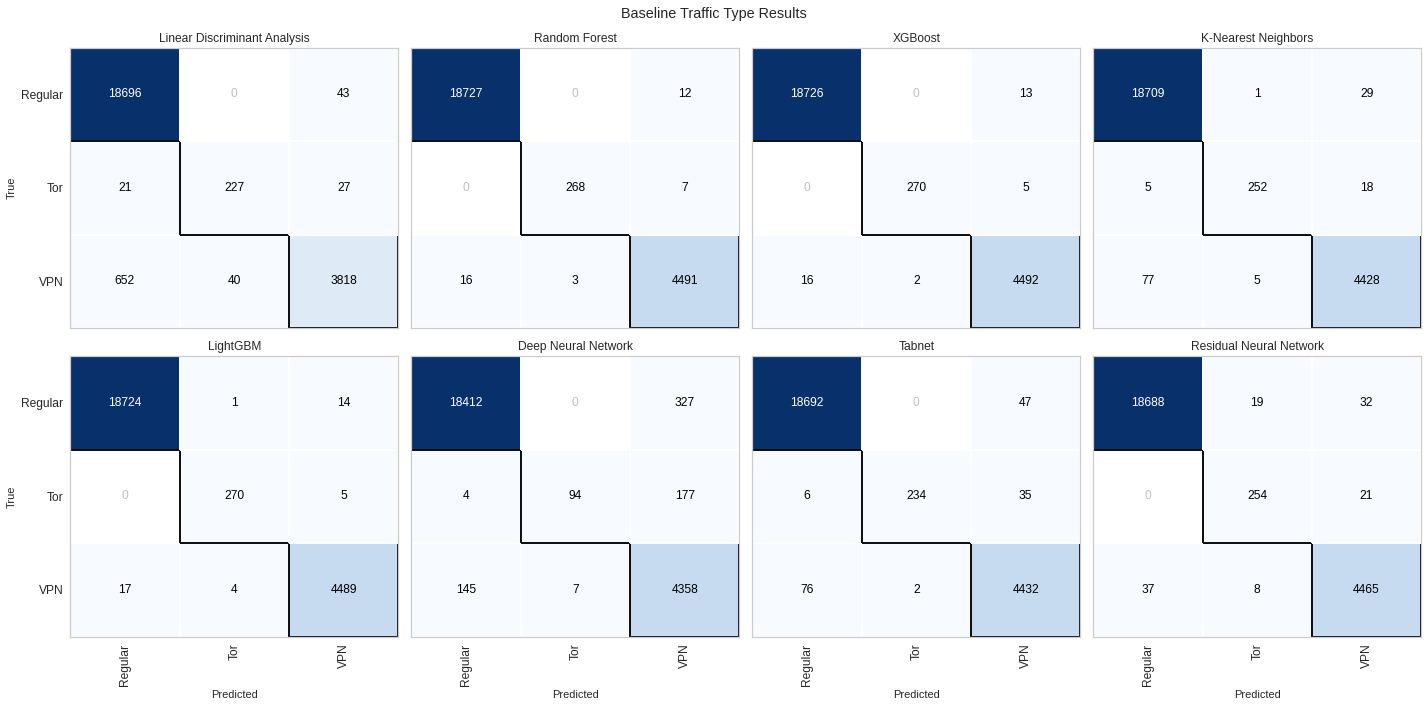

In [58]:
classifiers = [LinearDiscriminantAnalysis(), RandomForestClassifier(), XGBClassifier(), KNeighborsClassifier(),  LGBMClassifier(), "Deep Neural Network", "Tabnet", "Residual Neural Network"]
classifier_names = ["Linear Discriminant Analysis", "Random Forest", "XGBoost", "K-Nearest Neighbors", "LightGBM", "Deep Neural Network", "Tabnet", "Residual Neural Network"]
shallow_classifiers = ["Linear Discriminant Analysis", "Random Forest", "XGBoost", "K-Nearest Neighbors", "LightGBM"]
shape = tuple(100 for i in range(20))
baseline_traffic_dataset_results = train_and_evaluate_n_classifiers(baseline_traffic_dataset['Dataset'], classifiers, 'Traffic Type', classifier_names, shallow_classifiers, shape, "Baseline Traffic Type Results", epochs=20)

Results for Linear Discriminant Analysis
              precision    recall  f1-score   support

           0       0.72      0.62      0.67      2905
           1       0.65      0.79      0.71      6590
           2       0.48      0.26      0.34       966
           3       0.14      0.32      0.20       211
           4       0.59      0.23      0.33      1863
           5       0.82      0.86      0.84      9727
           6       0.30      0.21      0.25       970
           7       0.21      0.22      0.21       292

    accuracy                           0.70     23524
   macro avg       0.49      0.44      0.44     23524
weighted avg       0.69      0.70      0.68     23524

	Accuracy: 0.6984781499744941

	F1: 0.6837000348439087

	AUC: 0.8633486186418192

	Mathew's Correlation: 0.5759527942093119

Results for Random Forest
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2905
           1       0.89      0.94      0.91     

/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:45:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Results for XGBoost
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2905
           1       0.88      0.96      0.92      6590
           2       0.97      0.94      0.95       966
           3       0.86      0.79      0.82       211
           4       0.91      0.81      0.86      1863
           5       0.97      0.97      0.97      9727
           6       0.91      0.71      0.79       970
           7       0.98      0.94      0.96       292

    accuracy                           0.94     23524
   macro avg       0.93      0.88      0.91     23524
weighted avg       0.94      0.94      0.94     23524

	Accuracy: 0.9385733718755314

	F1: 0.9378532183076094

	AUC: 0.995858742335

/home/drake/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/drake/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/drake/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/drake/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_cl

loss: 0.8846938014030457, accuracy:  69.07%
Results for Deep Neural Network
              precision    recall  f1-score   support

           0       0.64      0.90      0.75      2905
           1       0.58      0.80      0.67      6590
           2       0.43      0.00      0.01       966
           3       0.69      0.09      0.15       211
           4       0.74      0.49      0.59      1863
           5       0.86      0.71      0.78      9727
           6       0.47      0.39      0.42       970
           7       0.87      0.30      0.45       292

    accuracy                           0.69     23524
   macro avg       0.66      0.46      0.48     23524
weighted avg       0.71      0.69      0.67     23524

	Accuracy: 0.6907413705152186

	F1: 0.6741231273129592

	AUC: 0.8762092964285957

	Mathew's Correlation: 0.5803498746929425



/home/drake/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/drake/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/drake/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Tabnet
              precision    recall  f1-score   support

           0       0.64      0.90      0.75      2905
           1       0.60      0.90      0.72      6590
           2       0.77      0.02      0.04       966
           3       0.58      0.34      0.43       211
           4       0.70      0.53      0.60      1863
           5       0.97      0.68      0.80      9727
           6       0.48      0.34      0.40       970
           7       0.51      0.78      0.62       292

    accuracy                           0.71     23524
   macro avg       0.66      0.56      0.54     23524
weighted avg       0.77      0.71      0.70     23524

	Accuracy: 0.7131865329025676

	F1: 0.7007799972503536

	AUC: 0.8888634465246985

	Mathew's Correlation: 0.6266810704612056

Layer sizes: [64, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 8], length: 22
Number of residual blocks: 19
Residual locations:  [1, 2, 3, 4, 5, 6, 7,

/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be rem

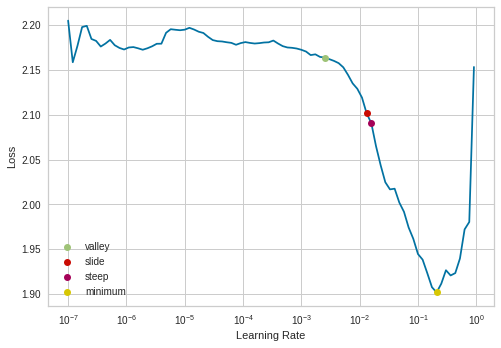

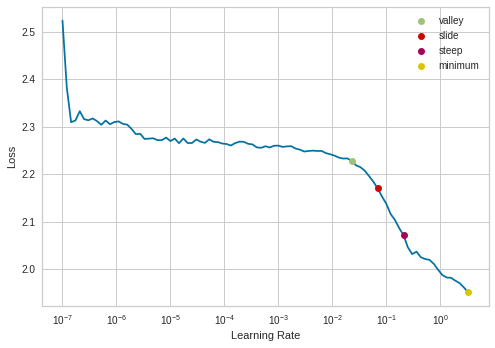

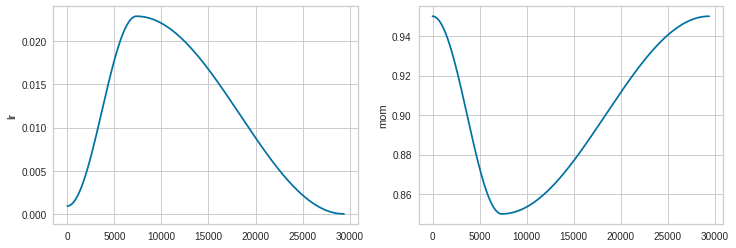

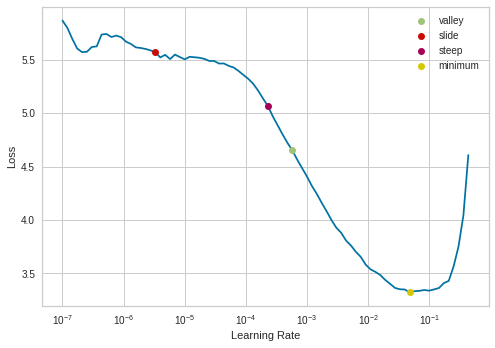

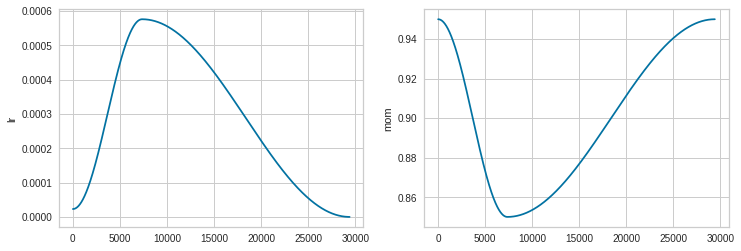

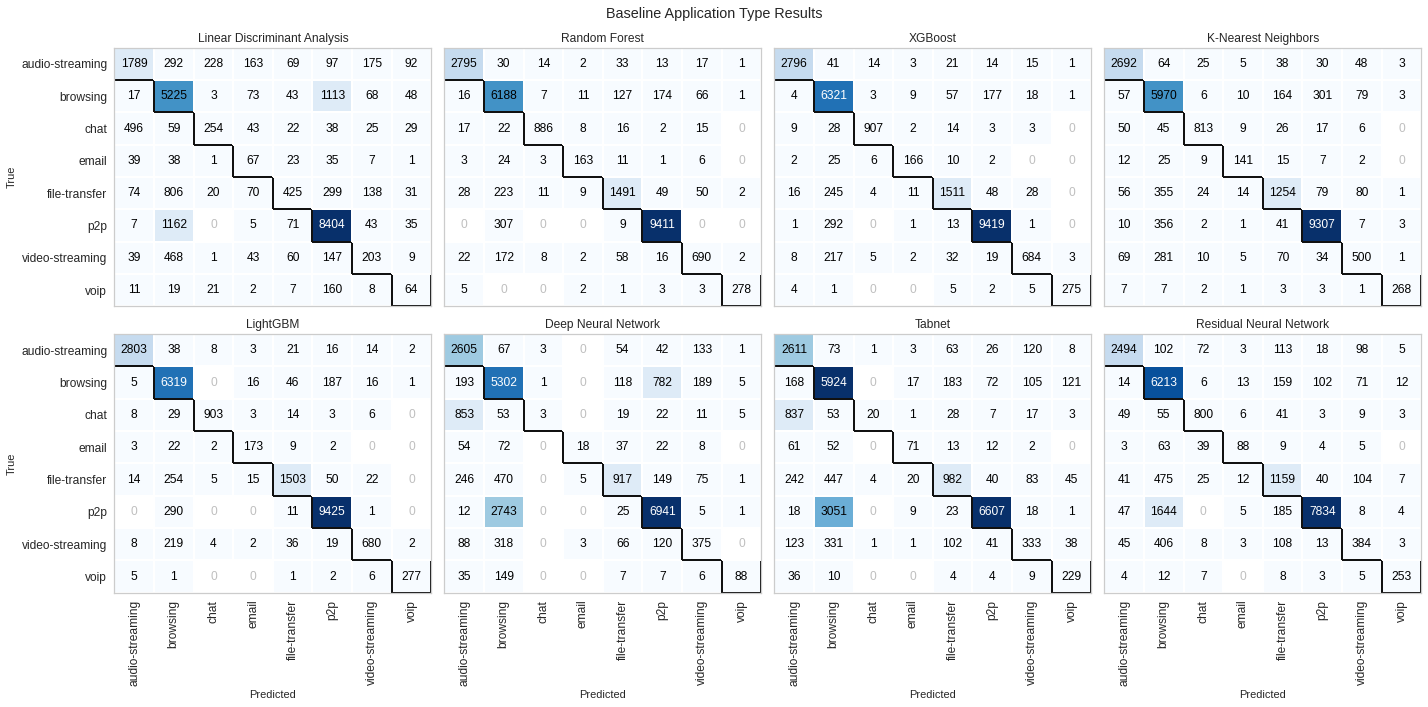

In [59]:
baseline_application_dataset_results = train_and_evaluate_n_classifiers(baseline_application_dataset['Dataset'], classifiers, 'Application Type', classifier_names, shallow_classifiers, shape, "Baseline Application Type Results", epochs=20)

# Augmented Traffic Type Results

Results for Linear Discriminant Analysis
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      3993
           1       0.95      0.84      0.89       972
           2       0.88      0.90      0.89      3035

    accuracy                           0.91      8000
   macro avg       0.92      0.89      0.90      8000
weighted avg       0.91      0.91      0.91      8000

	Accuracy: 0.91025

	F1: 0.9101157817337837

	AUC: 0.9685854213748284

	Mathew's Correlation: 0.847495486909137

Results for Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3993
           1       1.00      0.99      1.00       972
           2       0.99      1.00      1.00      3035

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000

	Accuracy: 0.99675

	F1: 0.9967500675154192

	AUC: 0.99979

/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:10:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Results for XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3993
           1       1.00      0.99      1.00       972
           2       1.00      1.00      1.00      3035

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000

	Accuracy: 0.997375

	F1: 0.9973746863770976

	AUC: 0.9998603180176963

	Mathew's Correlation: 0.9955668267597838

Results for K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3993
           1       0.98      0.98      0.98       972
           2       0.98      0.98   

/home/drake/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/drake/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 0.577388346195221, accuracy:  85.93%
Results for Deep Neural Network
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3993
           1       0.38      0.03      0.06       972
           2       0.75      0.96      0.84      3035

    accuracy                           0.86      8000
   macro avg       0.70      0.66      0.63      8000
weighted avg       0.82      0.86      0.82      8000

	Accuracy: 0.85925

	F1: 0.8157469922125076

	AUC: 0.9310314876479829

	Mathew's Correlation: 0.768103267474915

Results for Tabnet
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3993
           1       0.99      0.90      0.94       972
           2       0.96      0.99      0.97      3035

    accuracy                           0.98      8000
   macro avg       0.98      0.96      0.97      8000
weighted avg       0.98      0.98      0.98      8000

	Accuracy: 0.9795

	F1: 0.97927

/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be rem

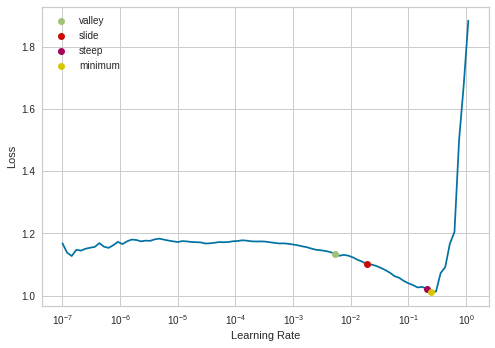

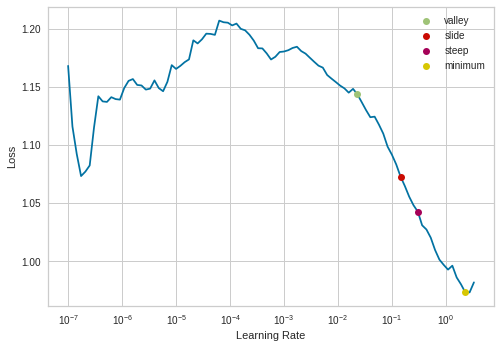

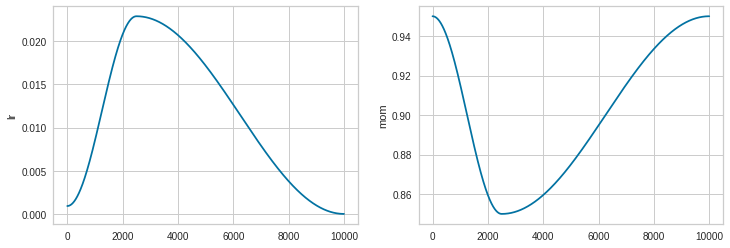

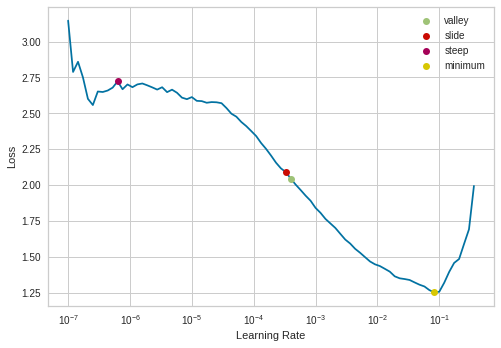

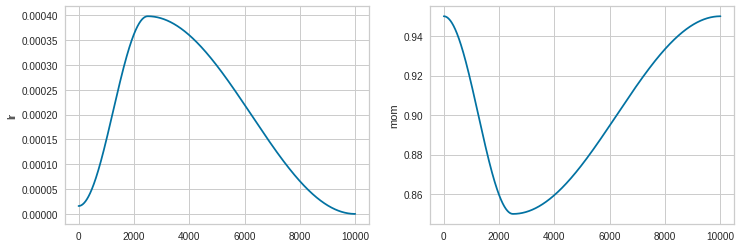

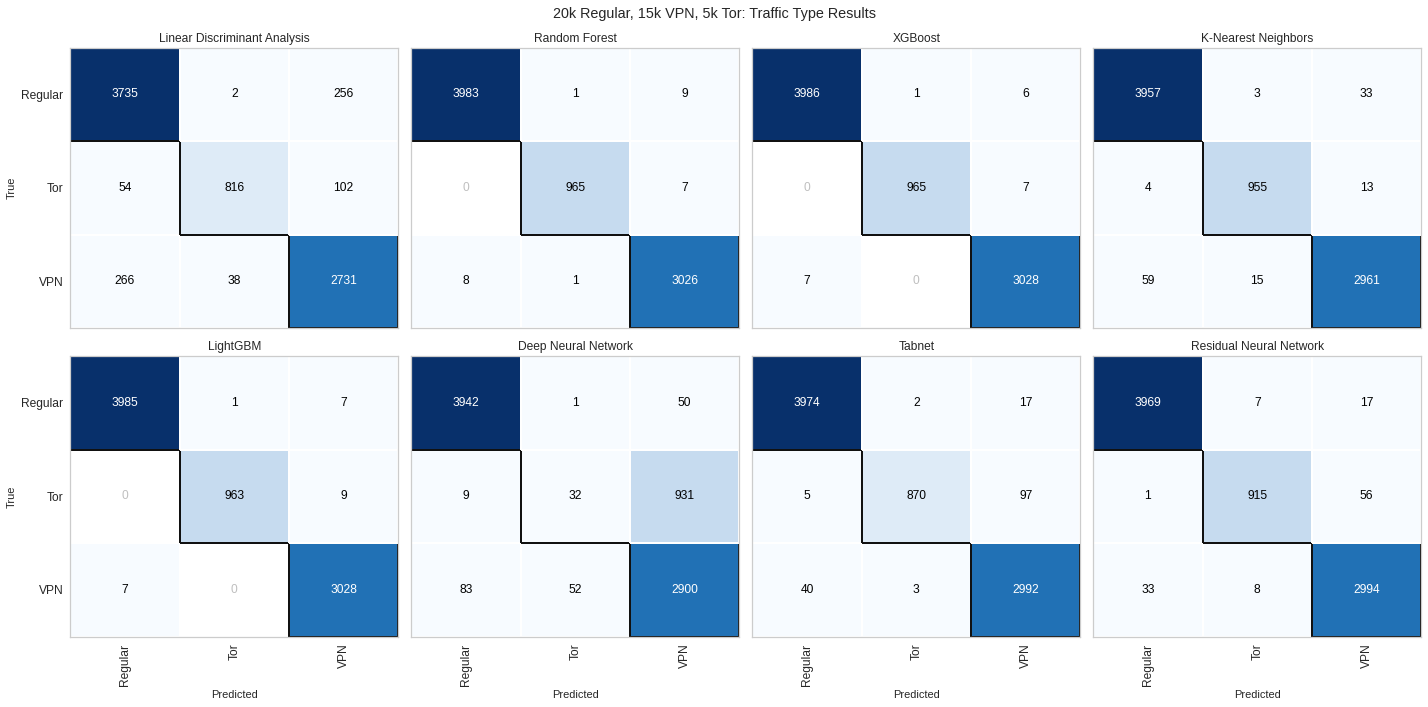

In [60]:
smote_balanced_traffic_labels_dataset_20_15_5_results = train_and_evaluate_n_classifiers(smote_balanced_traffic_labels_dataset_20_15_5['Dataset'], classifiers, 'Traffic Type', classifier_names, shallow_classifiers, shape, "20k Regular, 15k VPN, 5k Tor: Traffic Type Results", epochs=20)

Results for Linear Discriminant Analysis
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      3978
           1       0.98      0.86      0.92      3933
           2       0.84      0.90      0.86      4089

    accuracy                           0.89     12000
   macro avg       0.90      0.89      0.89     12000
weighted avg       0.90      0.89      0.89     12000

	Accuracy: 0.8931666666666667

	F1: 0.8939537207188646

	AUC: 0.9677365127713258

	Mathew's Correlation: 0.8412725122263779

Results for Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3978
           1       1.00      1.00      1.00      3933
           2       1.00      1.00      1.00      4089

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000

	Accuracy: 0.9979166666666667

	F1: 0.99791641

/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:18:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Results for XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3978
           1       1.00      1.00      1.00      3933
           2       1.00      1.00      1.00      4089

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000

	Accuracy: 0.9984166666666666

	F1: 0.9984166748110591

	AUC: 0.9999829205145914

	Mathew's Correlation: 0.997624710511949

Results for K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3978
           1       0.99      1.00      0.99      3933
           2       0.99    

/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be rem

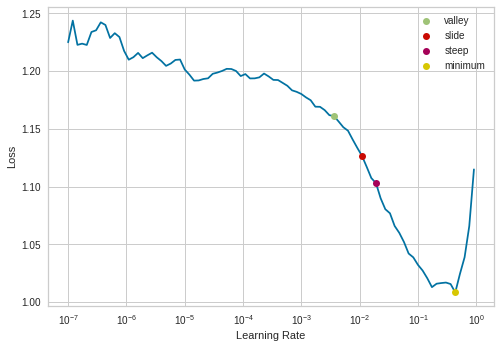

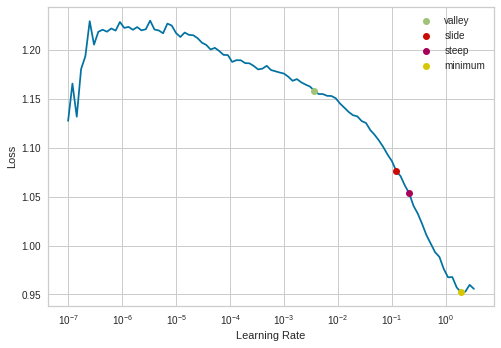

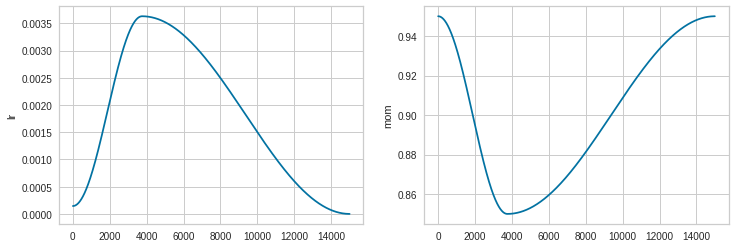

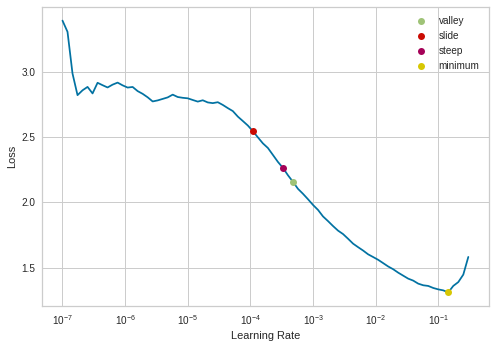

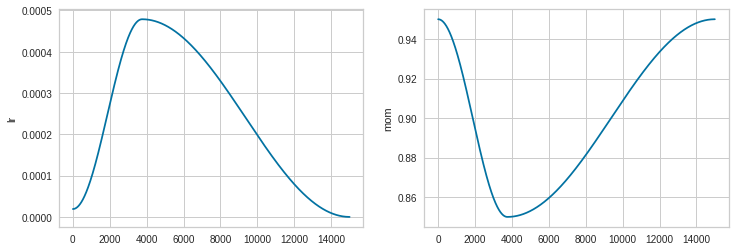

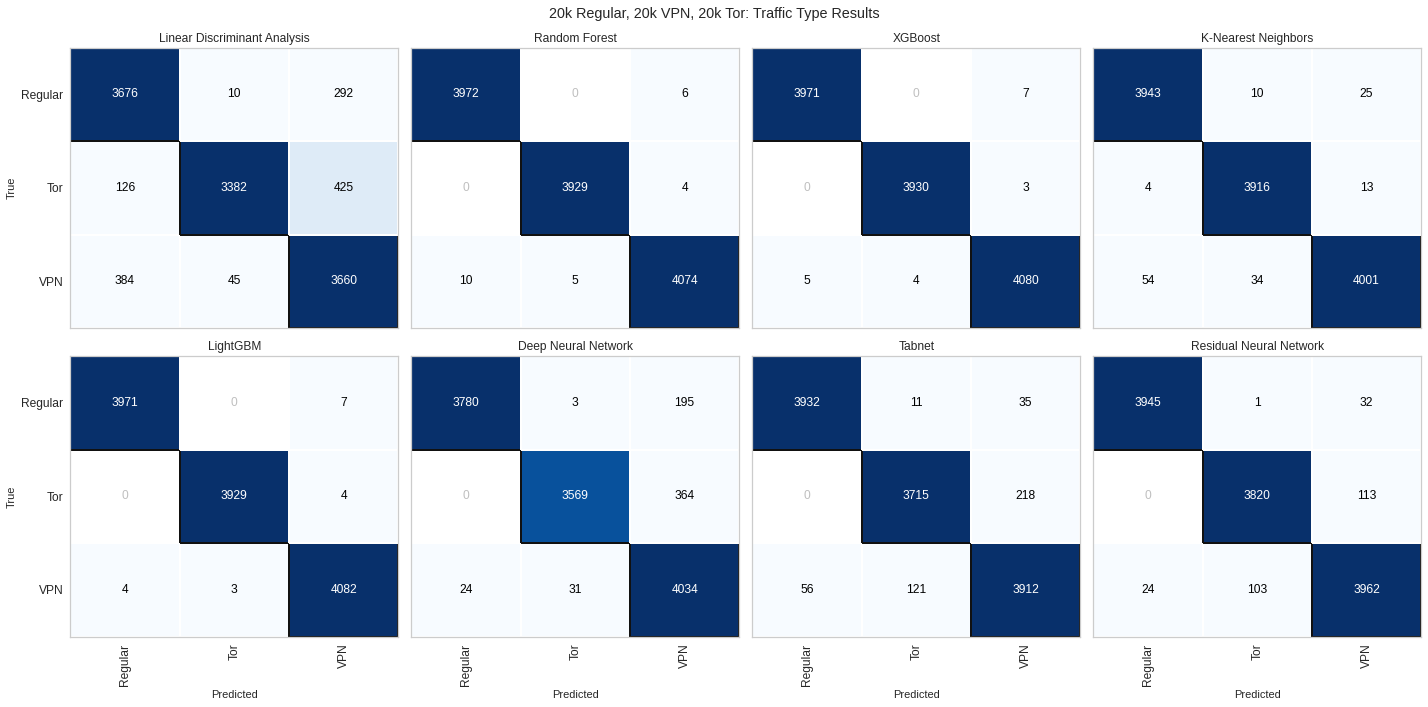

In [61]:
smote_balanced_traffic_labels_dataset_20_20_20 = train_and_evaluate_n_classifiers(smote_balanced_traffic_labels_dataset_20_20_20['Dataset'], classifiers, 'Traffic Type', classifier_names, shallow_classifiers, shape, "20k Regular, 20k VPN, 20k Tor: Traffic Type Results", epochs=20)

Results for Linear Discriminant Analysis
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      6006
           1       0.97      0.86      0.91      1925
           2       0.86      0.88      0.87      4069

    accuracy                           0.90     12000
   macro avg       0.91      0.89      0.90     12000
weighted avg       0.90      0.90      0.90     12000

	Accuracy: 0.90125

	F1: 0.9013927900830977

	AUC: 0.9722085468784535

	Mathew's Correlation: 0.8368530002750155

Results for Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6006
           1       1.00      1.00      1.00      1925
           2       1.00      1.00      1.00      4069

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000

	Accuracy: 0.9968333333333333

	F1: 0.9968334909855209

	

/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:30:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Results for XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6006
           1       1.00      1.00      1.00      1925
           2       1.00      1.00      1.00      4069

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000

	Accuracy: 0.9973333333333333

	F1: 0.9973336283960186

	AUC: 0.9999866117755237

	Mathew's Correlation: 0.9956212177252652

Results for K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6006
           1       0.98      0.99      0.98      1925
           2       0.99   

/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be rem

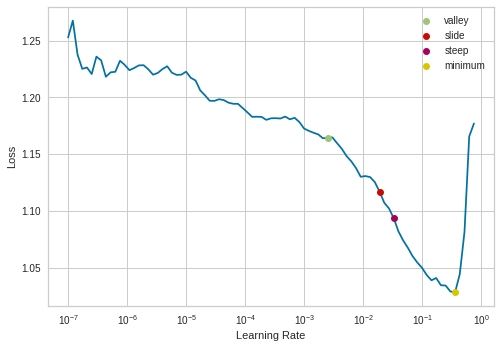

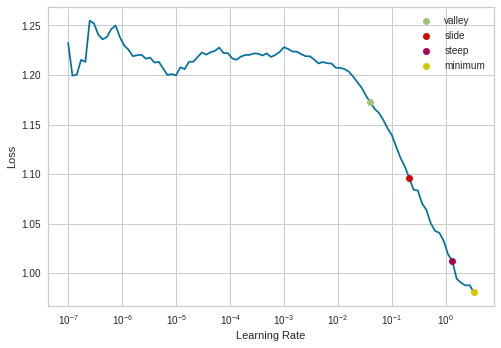

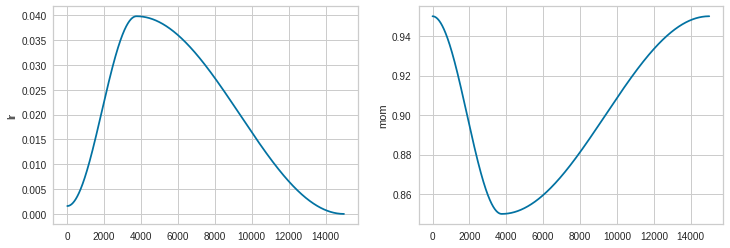

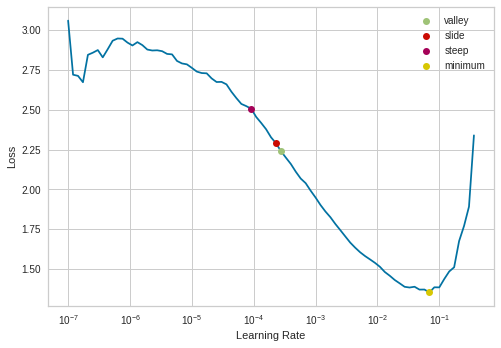

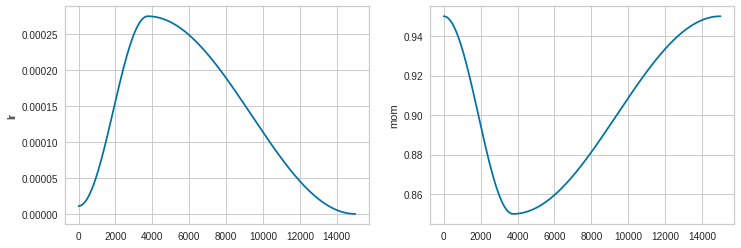

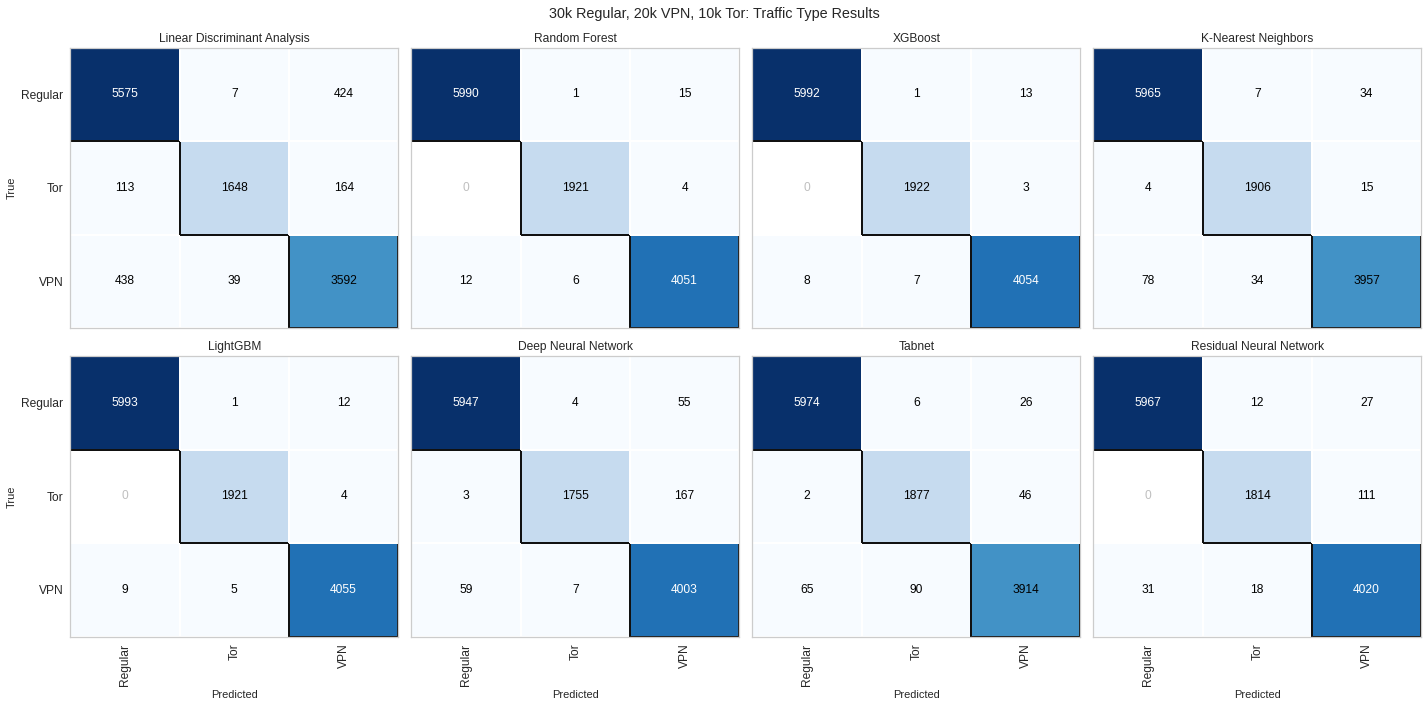

In [62]:
smote_balanced_traffic_labels_dataset_30_20_10 = train_and_evaluate_n_classifiers(smote_balanced_traffic_labels_dataset_30_20_10['Dataset'], classifiers, 'Traffic Type', classifier_names, shallow_classifiers, shape, "30k Regular, 20k VPN, 10k Tor: Traffic Type Results", epochs=20)

In [63]:
smote_balanced_traffic_labels_dataset_equal = train_and_evaluate_n_classifiers(smote_balanced_traffic_labels_dataset_equal['Dataset'], classifiers, 'Traffic Type', classifier_names, shallow_classifiers, shape, "93309 each: Traffic Type Results", epochs=20)

Results for Linear Discriminant Analysis
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     18484
           1       0.98      0.87      0.92     18770
           2       0.84      0.90      0.87     18731

    accuracy                           0.90     55985
   macro avg       0.90      0.90      0.90     55985
weighted avg       0.90      0.90      0.90     55985

	Accuracy: 0.8973653657229615

	F1: 0.8981452539929118

	AUC: 0.9706576208814922

	Mathew's Correlation: 0.8475417026523526

Results for Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18484
           1       1.00      1.00      1.00     18770
           2       1.00      1.00      1.00     18731

    accuracy                           1.00     55985
   macro avg       1.00      1.00      1.00     55985
weighted avg       1.00      1.00      1.00     55985

	Accuracy: 0.9989282843618826

	F1: 0.99892815

/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:44:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Results for XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18484
           1       1.00      1.00      1.00     18770
           2       1.00      1.00      1.00     18731

    accuracy                           1.00     55985
   macro avg       1.00      1.00      1.00     55985
weighted avg       1.00      1.00      1.00     55985

	Accuracy: 0.9989461462891847

	F1: 0.9989460470668545

	AUC: 0.9999962462872615

	Mathew's Correlation: 0.9984192643476458

Results for K-Nearest Neighbors
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18484
           1       1.00      1.00      1.00     18770
           2       1.00   

# Augmented Application Type Results

In [ ]:
smote_balanced_application_dataset_labels_10_10_10 = train_and_evaluate_n_classifiers(smote_balanced_application_dataset_labels_10_10_10['Dataset'], classifiers, 'Application Type', classifier_names, shallow_classifiers, shape, "10k Each: Application Type Results", epochs=20)

In [ ]:
smote_balanced_application_dataset_labels_15_15_15 = train_and_evaluate_n_classifiers(smote_balanced_application_dataset_labels_15_15_15['Dataset'], classifiers, 'Application Type', classifier_names, shallow_classifiers, shape, "15k Each: Application Type Results", epochs=20)

In [ ]:
smote_balanced_application_dataset_labels_20_20_20 = train_and_evaluate_n_classifiers(smote_balanced_application_dataset_labels_20_20_20['Dataset'], classifiers, 'Application Type', classifier_names, shallow_classifiers, shape, "20k Each: Application Type Results", epochs=20)

In [ ]:
smote_balanced_application_dataset_labels_25_25_25 = train_and_evaluate_n_classifiers(smote_balanced_application_dataset_labels_25_25_25['Dataset'], classifiers, 'Application Type', classifier_names, shallow_classifiers, shape, "25k Each: Application Type Results", epochs=20)

In [ ]:
smote_balanced_application_dataset_labels_30_30_30 = train_and_evaluate_n_classifiers(smote_balanced_application_dataset_labels_30_30_30['Dataset'], classifiers, 'Application Type', classifier_names, shallow_classifiers, shape, "30k Each: Application Type Results", epochs=20)

In [ ]:
smote_balanced_application_dataset_labels_equal = train_and_evaluate_n_classifiers(smote_balanced_application_dataset_labels_equal['Dataset'], classifiers, 'Application Type', classifier_names, shallow_classifiers, shape, "Equal Proportions: Application Type Results", epochs=20)